In [ ]:
# pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load all libraries
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
MODEL_PATH = "bert-base-uncased"

## Load Dataset

In [ ]:
# #get SQuAD v2
# !wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
# !wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

In [ ]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [ ]:
#note: below code will only return questions wich have answers (i.e. not the ones flagged as imposible to answer)
def get_data(path):
    #read each file and retrieve the contexts, qustions and answers
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
data_path = 'drive/MyDrive/DLT8803/train-v2.0.json'

In [ ]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data(data_path)
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp
print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")


Total number of questions: 130319
Total number of Answerable questions: 86821
Total number of impossible questions: 43498


In [ ]:
print(train_questions[0])
print(train_contexts[0])
print(train_answers[0])

when did beyonce start becoming popular?
beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
{'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
data_path = 'drive/MyDrive/DLT8803/dev-v2.0.json'

In [ ]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data(data_path)
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 142192
Total number of Answerable questions: 92749
Total number of impossible questions: 49443


In [ ]:
print(valid_questions[0])
print(valid_contexts[0])
print(valid_answers[0])

in what country is normandy located?
the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
{'text': 'France', 'answer_start': 159}


In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [ ]:
print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
Question: when did beyonce start becoming popular?
Answer: {'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [ ]:
test_rec = 0
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: in what country is normandy located?
Answer: {'text': 'france', 'answer_start': 159, 'answer_end': 165}


In [ ]:
## Limiting the training and validation data to n records
pick_n = 2500
train_contexts2 = train_contexts[0:pick_n]
train_answers2 = train_answers[0:pick_n]
train_questions2 = train_questions[0:pick_n]
print(f"Context: {len(train_contexts2)}")
print(f"Question: {len(train_questions2)}")
print(f"Answer: {len(train_answers2)}")

valid_contexts2 = valid_contexts[0:pick_n]
valid_answers2 = valid_answers[0:pick_n]
valid_questions2 = valid_questions[0:pick_n]

print(f"Context: {len(valid_contexts2)}")
print(f"Question: {len(valid_questions2)}")
print(f"Answer: {len(valid_answers2)}")

Context: 2500
Question: 2500
Answer: 2500
Context: 2500
Question: 2500
Answer: 2500


## Tokenize

### Find max lengths

346


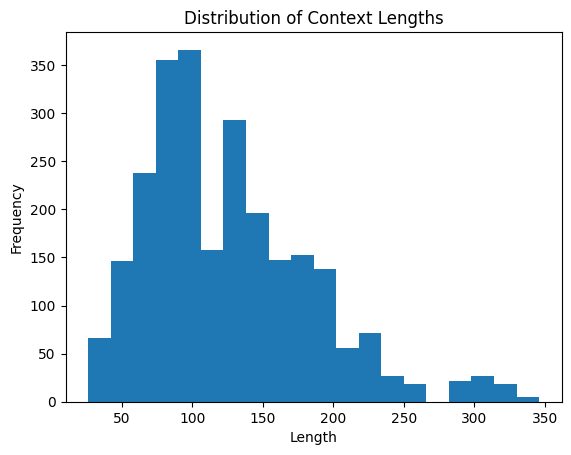

In [ ]:
#Text lengths to contextx
token_lens = []

for txt in train_contexts2:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

29
2500


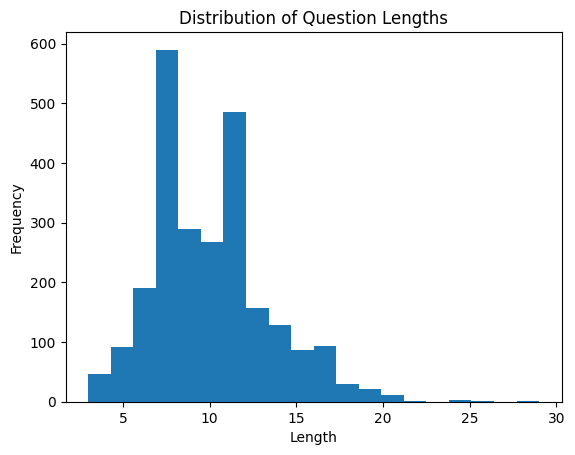

In [ ]:
#Test lengths of Questions
token_lens2 = []

for txt in train_questions2:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 400

### tokenize

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions2, train_contexts2,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions2,valid_contexts2,  max_length = MAX_LENGTH, truncation=True, padding=True)


In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:

print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
2500
400


In [ ]:
print(train_encodings_fast['input_ids'][0])

[101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193, 1011, 2028, 3895, 1000, 4689

In [ ]:
type(train_answers2[0]['text'])
train_answers2[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
train_answers2[0]

{'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}

In [ ]:
#train_answer_encodings_fast = tokenizerFast(train_answers[0]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)


In [ ]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers2[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)


In [ ]:
test_rec=0

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers2[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

75 79
in the late 1990s
in the late 1990s
[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
2500


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

21


In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
2500


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers2[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

68
71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers2[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

5


In [ ]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers2[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

france
france
[CLS] in what country is normandy located? [SEP] the normans ( norman : nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ( " norman " comes from " norseman " ) raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman - gaulish populations, their descendants would gradually merge with the carolingian - based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
2500
2500
2500
2500
2500
2500


In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny\'s child. managed by her father, mathew knowles, the group became one of the world\'s best - selling girl groups of all time. their hiatus saw the release of beyonce\'s debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
test_row= 0
print(train_contexts2[test_row][train_answers2[test_row]['answer_start']:train_answers2[test_row]['answer_end']])

in the late 1990s


In [ ]:

answer_start_index = 75
answer_end_index = 79

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

'in the late 1990s'

## OPTIONAL: try a pretrained model. (uncomment to test out)

In [ ]:
#tokenizer2 = BertTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
#model2 = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")

In [ ]:
#question= train_questions2[0]
#text = train_contexts2[0]

#print(question)
#print(text)


In [ ]:
#inputs = tokenizer2(question, text, return_tensors="pt")
#with torch.no_grad():
#    outputs = model2(**inputs)

In [ ]:
#answer_start_index = outputs.start_logits.argmax()
#answer_end_index = outputs.end_logits.argmax()
#print(answer_start_index)
#print(answer_end_index)



In [ ]:
#predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
#tokenizer2.decode(predict_answer_tokens)

## Create Dataset and Dataloaders

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
print(len(train_dataset))
print(train_dataset[0].keys())

2500
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:

#print(data['targets'].shape)

## Create Model

In [ ]:
#model = BertForQuestionAnswering.from_pretrained(MODEL_PATH)

In [ ]:
bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [ ]:
model = QAModel()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Create Loss Functions

In [ ]:
# my function to manually calculate Cross Entropy Loss
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
# # my focal loss function. Focal Loss = (True Vector)*((1 - probs)^Gamma)*log(probs)
# # where Gamma is a factor we use. setting Gamma = 0 makes this a Cross Entropy Loss function

# def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

#     #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
#     smax = nn.Softmax(dim=1)
#     probs_start = smax(start_logits)
#     inv_probs_start = 1 - probs_start
#     probs_end = smax(end_logits)
#     inv_probs_end = 1 - probs_end

#     #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
#     lsmax = nn.LogSoftmax(dim=1)
#     log_probs_start = lsmax(start_logits)
#     log_probs_end = lsmax(end_logits)

#     nll = nn.NLLLoss()

#     fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
#     fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

#     #return mean of the Loss for the start and end logits
#     return ((fl_start + fl_end)/2)

### OPTIONAL: Uncomment this code if you want to test on one input .....

In [ ]:
#data = next(iter(train_data_loader))
#data.keys()

In [ ]:
#print(data['input_ids'].shape)
#print(data['attention_mask'].shape)

In [ ]:
#run one row
#model.to(device)
#model.train()
#input_ids = data['input_ids'][0].unsqueeze(0).to(device)
#attention_mask = data['attention_mask'][0].unsqueeze(0).to(device)
#start_positions = data['start_positions'][0].unsqueeze(0).to(device)
#end_positions = data['end_positions'][0].unsqueeze(0).to(device)

In [ ]:
#out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

In [ ]:
#print(f"start logits shape: {out_start.shape}")
#print(f"end logits shape: {out_end.shape}")

In [ ]:
#answer_start_index = out_start.argmax()
#answer_end_index = out_end.argmax()
#print(answer_start_index)
#print(answer_end_index)

## Train Loop

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        # loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()

        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
        #ret_loss = sum(losses)/len(losses)
    return(ret_acc)

In [ ]:
EPOCHS = 4
train_acc_list =[]
train_loss_list =[]
val_acc_list = []
model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    val_acc_list.append(val_acc)
    print(f"Validation Accuracy: {val_acc}")

#val_acc, val_loss = eval_model(model, valid_data_loader)
#print(f"Validation Accuracy: {val_acc}   Validation Loss: {val_loss}")


Running Epoch : 100%|██████████| 157/157 [03:02<00:00,  1.16s/it]


Train Accuracy: 0.2099920382165605      Train Loss: 3.59431700114232


Running Evaluation: 100%|██████████| 79/79 [01:05<00:00,  1.21it/s]


Validation Accuracy: 0.4052610759493671


Running Epoch : 100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


Train Accuracy: 0.6060907643312102      Train Loss: 1.5351751332829713


Running Evaluation: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s]


Validation Accuracy: 0.4768591772151899


Running Epoch : 100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


Train Accuracy: 0.7573646496815286      Train Loss: 0.8933487745227328


Running Evaluation: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s]


Validation Accuracy: 0.4861550632911392


Running Epoch : 100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


Train Accuracy: 0.8355891719745223      Train Loss: 0.5680086950587618


Running Evaluation: 100%|██████████| 79/79 [01:06<00:00,  1.20it/s]

Validation Accuracy: 0.4899129746835443


In [ ]:
scheduler.get_last_lr()

[1.3122e-05]

In [ ]:
print(f'Final Train Accuracy:{train_acc}')
print(f'Final Val Accuracy:{val_acc}')

Final Train Accuracy:0.8355891719745223
Final Val Accuracy:0.4899129746835443


In [ ]:
import pandas as pd

In [ ]:
d = {"epoch":[1,2,3,4],
                     "Train Accuracy":train_acc_list,
                     "Train Loss": train_loss_list,
                     "Validation Accuracy": val_acc_list}
table = pd.DataFrame(data=d)
table

,epoch,Train Accuracy,Train Loss,Validation Accuracy
0,1,0.209992,3.594317,0.405261
1,2,0.606091,1.535175,0.476859
2,3,0.757365,0.893349,0.486155
3,4,0.835589,0.568009,0.489913


from matplotlib import pyplot as plt
table['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['Train Accuracy'].plot(kind='hist', bins=20, title='Train Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['Train Loss'].plot(kind='hist', bins=20, title='Train Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['Validation Accuracy'].plot(kind='hist', bins=20, title='Validation Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='epoch', y='Train Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='Train Accuracy', y='Train Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='Train Loss', y='Validation Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Train Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Train Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Train Accuracy']
  ys = series['Train Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('Train Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Train Accuracy')
_ = plt.ylabel('Train Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Train Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Train Accuracy'}, axis=1)
              .sort_values('Train Accuracy', ascending=True))
  xs = counted['Train Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('Train Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Train Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
table['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['Train Accuracy'].plot(kind='line', figsize=(8, 4), title='Train Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['Train Loss'].plot(kind='line', figsize=(8, 4), title='Train Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['Validation Accuracy'].plot(kind='line', figsize=(8, 4), title='Validation Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

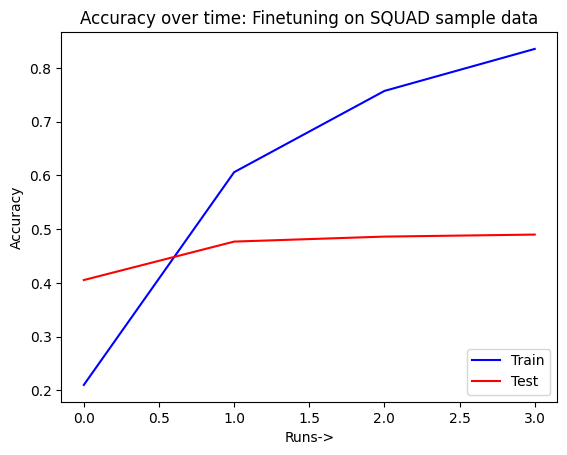

In [ ]:
# plot Accuracy
plt.plot(train_acc_list, color='blue',label ='Train')
plt.plot(val_acc_list, color='red',label= 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.legend(loc='lower right')
plt.title("Accuracy over time: Finetuning on SQUAD sample data");

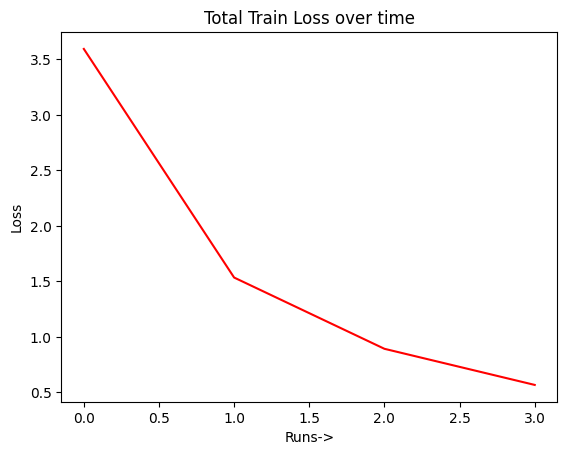

In [ ]:
# plot Loss
plt.plot(train_loss_list, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/DLT8803/best_model_state.bin')

In [ ]:
model.state_dict()

OrderedDict([('bert.embeddings.word_embeddings.weight',
              tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0198, -0.0372, -0.0097],
                      [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
                      [-0.0197, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
                      ...,
                      [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
                      [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
                      [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
                     device='cuda:0')),
             ('bert.embeddings.position_embeddings.weight',
              tensor([[ 0.0173, -0.0251, -0.0364,  ..., -0.0009,  0.0008,  0.0157],
                      [ 0.0075,  0.0021, -0.0201,  ...,  0.0293,  0.0292, -0.0047],
                      [-0.0125, -0.0028, -0.0115,  ...,  0.0148,  0.0194, -0.0077],
                      ...,
                      [ 0.0174,  

## Test

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: in what country is normandy located?
Expected Answer: {'text': 'france', 'answer_start': 159, 'answer_end': 165}
Predicted Answer: france


In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: who was the norse leader?
Expected Answer: {'text': 'rollo', 'answer_start': 308, 'answer_end': 313}
Predicted Answer: rollo


In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the norman dynasty had a major political, cultural and military impact on medieval europe and even the near east. the normans were famed for their martial spirit and eventually for their christian piety, becoming exponents of the catholic orthodoxy into which they assimilated. they adopted the gallo-romance language of the frankish land they settled, their dialect becoming known as norman, normaund or norman french, an important literary language. the duchy of normandy, which they formed by treaty with the french crown, was a great fief of medieval france, and under richard i of normandy was forged into a cohesive and formidable principality in feudal tenure. the normans are noted both for their culture, such as their unique romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. norman adventurers founded the kingdom of sicily under roger ii after conquering southern italy on the saracens and byzantines, and an exped

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: as of august 2010, victoria had 1,548 public schools, 489 catholic schools and 214 independent schools. just under 540,800 students were enrolled in public schools, and just over 311,800 in private schools. over 61 per cent of private students attend catholic schools. more than 462,000 students were enrolled in primary schools and more than 390,000 in secondary schools. retention rates for the final two years of secondary school were 77 per cent for public school students and 90 per cent for private school students. victoria has about 63,519 full-time teachers.
Question: how many full time teachers does victoria have?
Expected Answer: {'text': '63,519', 'answer_start': 541, 'answer_end': 547}
Predicted Answer: 63, 519
